<a href="https://colab.research.google.com/github/steimel60/ML/blob/main/DeepLearning/ThreeOrSeven.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [193]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *

In [194]:
#Load in images of 3s and 7s
path = untar_data(URLs.MNIST_SAMPLE)
#List things in the path
path.ls()

(#3) [Path('/root/.fastai/data/mnist_sample/train'),Path('/root/.fastai/data/mnist_sample/labels.csv'),Path('/root/.fastai/data/mnist_sample/valid')]

In [195]:
#Get image paths for 3s and 7s
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('/root/.fastai/data/mnist_sample/train/3/10.png'),Path('/root/.fastai/data/mnist_sample/train/3/10000.png'),Path('/root/.fastai/data/mnist_sample/train/3/10011.png'),Path('/root/.fastai/data/mnist_sample/train/3/10031.png'),Path('/root/.fastai/data/mnist_sample/train/3/10034.png'),Path('/root/.fastai/data/mnist_sample/train/3/10042.png'),Path('/root/.fastai/data/mnist_sample/train/3/10052.png'),Path('/root/.fastai/data/mnist_sample/train/3/1007.png'),Path('/root/.fastai/data/mnist_sample/train/3/10074.png'),Path('/root/.fastai/data/mnist_sample/train/3/10091.png')...]

In [196]:
#Show image
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

In [197]:
#Image data can be represented in arrays
#Here is our image in a numpy array - showing rows and cols 4 through 10
array(im3)[4:10,4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

In [198]:
#And now as a PyTorch Tensor
tensor(im3)[4:10,4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

In [199]:
#Use pandas to color code the values, giving us a better representation
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15,4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


In [200]:
#Store all image in tensors
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors), len(seven_tensors)

(6131, 6265)

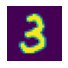

In [201]:
#use fastai show_image to display image in tensor
show_image(three_tensors[92])

In [202]:
#Our initial approach we are going to get average of all pixels
#To do this we will stack all images of each number into a single tensor
stacked_threes = torch.stack(three_tensors).float()/255
stacked_sevens = torch.stack(seven_tensors).float()/255

#Size gives us the length of each axis in a tensor
#Here we have count, pixels width, pixels height
stacked_threes.shape

torch.Size([6131, 28, 28])

In [203]:
#The length of the shape is a tensor's rank
len(stacked_threes.shape)

3

In [204]:
#Rank can also be accessed with ndim
stacked_threes.ndim 

3

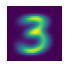

In [205]:
#To get the average of all images we call the mean method on dim 0 of stack
mean3 = stacked_threes.mean(0)
show_image(mean3)

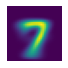

In [206]:
#Now for our set of 7s
mean7 = stacked_sevens.mean(0)
show_image(mean7)

In [207]:
#We can test to see how far a test image is from the avg 3 or avg 7
a_3 = stacked_threes[2] #Test img
#Get absloute val of pixel differences to avoid cancellation of "too light" and "too dark"
dist_3_abs = (a_3 - mean3).abs().mean() #dist to avg 3
dist_7_abs = (a_3 - mean7).abs().mean() #dist to avg 7
dist_3_abs, dist_7_abs #Dist to 3 is smaller, so model picks 3

(tensor(0.1100), tensor(0.1541))

In [208]:
#We can do a similar thing by squaring the differences (to get a positive) then taking the root
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt() #to 3
dist_7_sqr = ((a_3 - mean7)**2).mean().sqrt() #to 7
dist_3_sqr, dist_7_sqr #again 3 is a better solution

(tensor(0.1980), tensor(0.2974))

In [209]:
#Pytorch already provides these as loss functions
F.l1_loss(a_3.float(),mean7), F.mse_loss(a_3,mean7).sqrt()

(tensor(0.1541), tensor(0.2974))

In [210]:
#Create tensor objs for validation set
valid_3_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'3').ls()])
valid_7_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'7').ls()])
#Change float to 0 to 1
valid_3_tens = valid_3_tens.float() / 255
valid_7_tens = valid_7_tens.float() / 255
#Print size
valid_3_tens.shape, valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [211]:
#Create func to determine distance of an image to a mean
def mnist_distance(a,b): return (a-b).abs().mean((-1,-2))
mnist_distance(a_3, mean3)

tensor(0.1100)

In [212]:
#Get dist of all images in validation set
valid_3_dist = mnist_distance(valid_3_tens, mean3)
valid_3_dist, valid_3_dist.shape

(tensor([0.1133, 0.1357, 0.1406,  ..., 0.1233, 0.1166, 0.1109]),
 torch.Size([1010]))

In [213]:
#Func to determine 3 or 7
def is_3(x): return mnist_distance(x, mean3) < mnist_distance(x, mean7)
#See if it works
is_3(a_3), is_3(a_3).float()

(tensor(True), tensor(1.))

In [214]:
#Thanks to broadcasting we can tet entire validation set
is_3(valid_3_tens)

tensor([ True, False,  True,  ...,  True,  True,  True])

In [215]:
#We can test the accuracy by getting the average of the bool vals
acc_3 = is_3(valid_3_tens).float().mean()
acc_7 = 1 - is_3(valid_7_tens).float().mean()
acc_3, acc_7

(tensor(0.9168), tensor(0.9854))

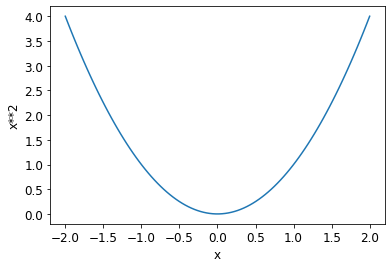

In [216]:
#Stocahastic Gradient Example
def f(x): return x**2
plot_function(f, 'x', 'x**2')

In [217]:
#Create tensor and tell it that we need gradients
xt = tensor(3.).requires_grad_()
#Calculate f(xt)
yt = f(xt)
yt #tensor obj that has gradient

tensor(9., grad_fn=<PowBackward0>)

In [218]:
#calculate gradient
yt.backward()
#We can now view the gradients
xt.grad

tensor(6.)

In [219]:
#we can do this on vectors as well
xt = tensor([3.,4.,10.]).requires_grad_()
xt

tensor([ 3.,  4., 10.], requires_grad=True)

In [220]:
def f(x): return (x**2).sum() #add sum so we can handle vectors
yt = f(xt)
yt.backward()
xt.grad

tensor([ 6.,  8., 20.])

## Below we will cover the learning rate, which is the coefficent we use to decide how far we move based on the gradient calculated

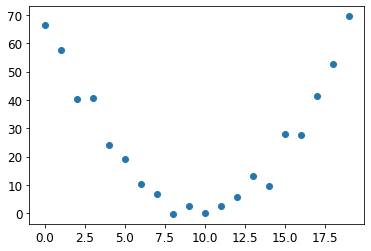

In [221]:
#Get some data
time = torch.arange(0,20).float()
speed = torch.randn(20)*3 + .75*(time-9.5)**2 + 1
plt.scatter(time, speed)

In [222]:
#separate time and parameters
#We restrict the best function to the best 'quadratic' function
def f(t, params):
  a, b, c = params
  return a*(t**2) + (b*t) + c

In [223]:
def mse(preds, targets): return ((preds-targets)**2).mean()

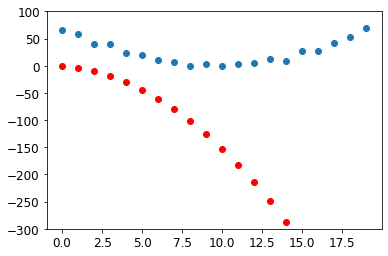

In [224]:
#Step 1: Initialize Parameters
params = torch.randn(3).requires_grad_()  #Random starting pos
#Step 2: Calculate Predictions
preds = f(time, params)
  #Show how good predictions are
def show_preds(preds, ax=None):
  if ax is None: ax = plt.subplots()[1]
  ax.scatter(time, speed)
  ax.scatter(time, to_np(preds), color='red')
  ax.set_ylim(-300,100)
show_preds(preds)

In [225]:
#Step 3: Calculate Loss
loss = mse(preds, speed)
loss

tensor(71071.8906, grad_fn=<MeanBackward0>)

In [226]:
#Step 4: Calculate Gradients
loss.backward()
params.grad

tensor([-88979.8438,  -5743.0059,   -416.5849])

In [227]:
#Step 5: Step the weights
lr = .00001
params.data -= lr * params.grad.data #Step
params.grad = None  #Clear gradients
#See if we improved
preds = f(time,params)
mse(preds,speed)

tensor(14026.3125, grad_fn=<MeanBackward0>)

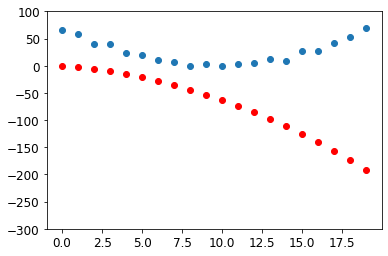

In [228]:
#Show in plot
show_preds(preds)

In [229]:
#Def above as func
def apply_step(params, prn=True):
  preds = f(time,params)
  loss = mse(preds, speed)
  loss.backward()
  params.data -= lr * params.grad.data
  params.grad = None
  if prn: print(loss.item())
  return preds

In [230]:
#Step 6: Repeat the process
for i in range(10): apply_step(params)

14026.3125
3231.53466796875
1188.8197021484375
802.2618408203125
729.0993041992188
715.2408447265625
712.6046142578125
712.0918579101562
711.98095703125
711.9461059570312


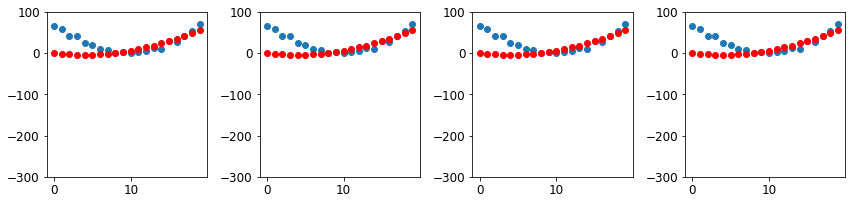

In [231]:
#Plot func at every step for better visual
_,axs = plt.subplots(1,4,figsize=(12,3))
for ax in axs: show_preds(apply_step(params, False), ax)
plt.tight_layout()

In [232]:
#Step 7: Stop
#In practice we'd watch the validation losses and metrics to determine a stopping parameter

## We now jump back into our 3s vs 7s example. In this section we will define a training objective

In [233]:
#Concatenate training data into list of vectors (rank 2)
#View can change shape withou changing contents, -1 means "make this axis as big as needed"
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)

#Label each image, 1 for 3 and 0 for 7
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_x.shape, train_y.shape #Make sure shapes match

(torch.Size([12396, 784]), torch.Size([12396, 1]))

In [234]:
#Dataset in PyTorch requires a return tuple of (x,y)
dset = list(zip(train_x, train_y))
x,y = dset[0]
x.shape, y

(torch.Size([784]), tensor([1]))

In [235]:
#Do same for validation data
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x, valid_y))

In [236]:
#Generate random init weight for each pixel
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()
weights = init_params((28*28,1))
bias = init_params(1)
#y = wx+b, w is weights b is bias

In [237]:
#Set up matrix multiplication using @ operator for fast iteration
def linear1(xb): return xb@weights + bias
preds = linear1(train_x)
preds

tensor([[  4.2706],
        [ -6.4684],
        [ -4.9104],
        ...,
        [ -0.2667],
        [ -9.8638],
        [-10.6865]], grad_fn=<AddBackward0>)

In [238]:
#Check our accuracy
corrects = (preds>0.0).float() == train_y #recall our labels are 0s and 1s so a match is a correct prediction
acc = corrects.float().mean().item()
acc

0.5726847648620605

In [239]:
"""We cant use acc as a loss func because small changes most likely wont change predictions
So our gradients would be 0 because old_acc = new_acc in that case
We can use confidience levels to help.

Let trgts be our labels and 3s = 1 and 7s = 0
Let prbs be our probability an image is a 3
    So .2 is pretty confident its a 7
    .9 is very confident its a 3
    .45 be not conmfident at all but pick 7

trgts = [1, 0, 1]
prbs = [.9, .45, .2]

then we can take our distances to each label and get an idea of our loss from the function below
"""

def mnist_loss(predictions, targets):
  predictions.sigmoid() #Just double check all our predictions are between 0 and 1
  return torch.where(targets==1, 1-predictions, predictions).mean() #1-preds when label 1, preds otherwise. Then get mean


## Next is the Optimization Step. For a blend of Optimization and Accuracy we use mini-batches. We calculate the average loss for the data in each mini-batch at the same time.

In [240]:
#Reinitialize our params
weights = init_params((28*28,1))
bias = init_params(1)
#Create a DataLoader from a Dataset
dl = DataLoader(dset, batch_size=256)
xb,yb = first(dl)
xb.shape, yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [241]:
#Do same for validation set
valid_dl = DataLoader(valid_dset, batch_size=256)
#Create mini-batch of size 4 for testing
batch = train_x[:4]
batch.shape

torch.Size([4, 784])

In [242]:
preds = linear1(batch)
#Calculate loss
loss = mnist_loss(preds, train_y[:4])
loss

tensor(-5.3930, grad_fn=<MeanBackward0>)

In [243]:
loss.backward()
weights.grad.shape, weights.grad.mean(), bias.grad

(torch.Size([784, 1]), tensor(-0.1511), tensor([-1.]))

In [244]:
#Put it all in a function
def calc_grad(xb, yb, model):
  preds = model(xb)             #Make prediction
  loss = mnist_loss(preds, yb)  #Calculate Loss
  loss.backward()               #Call gradient func

In [245]:
def train_epoch(model, lr, params):
  for xb, yb in dl:
    calc_grad(xb, yb, model)  #See cell above
    for p in params:
      p.data -= p.grad*lr     #Update parameters (weights/bias) by gradient * learning rate
      p.grad.zero_()          #Set gradients to zero or else they add up

In [246]:
def batch_accuracy(xb, yb):
  preds = xb.sigmoid()          #Get predicitons as prob between 0 and 1
  correct = (preds>.5) == yb    #Get correct predictions
  return correct.float().mean() #Return percent correct

In [247]:
#Putting all the batches together
def validate_epoch(model):
  accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]  #Get accuracy on validation set of all batches
  return round(torch.stack(accs).mean().item(), 4) #Return avg batch accuracy

In [248]:
#Results after 1 epoch
lr = .0001
params = weights,bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.4517

In [249]:
#For a few more epochs
for i in range(20):
  train_epoch(linear1, lr, params)
  print(validate_epoch(linear1), end=' ')

0.4537 0.4551 0.4551 0.4561 0.4571 0.4576 0.4586 0.461 0.462 0.4625 0.463 0.464 0.464 0.465 0.4664 0.4689 0.4703 0.4703 0.4708 0.4718 

In [250]:
#PyTorch provides some useful classes to make it easier to implement

#nn.Linear does same thing as our init_params and linear together
linear_model = nn.Linear(28*28,1)
w,b = linear_model.parameters() #we can get trainable parameters

#We can use this info to create an optimizer
class BasicOptim:
  def __init__(self, params, lr): self.params,self.lr = list(params), lr

  def step(self, *args, **kwargs):
    for p in self.params: p.data -= p.grad.data * self.lr
  
  def zero_grad(self, *args, **kwargs):
    for p in self.params: p.grad = None

opt = BasicOptim(linear_model.parameters(), lr) #Create optimizer instance

#we can now simplify our training loop
def train_epoch(model):
  for xb, yb in dl:
    calc_grad(xb, yb, model)
    opt.step()
    opt.zero_grad()
#Our validation func still works
validate_epoch(linear_model)

0.4594

In [251]:
def train_model(model, epochs):
  for i in range(epochs):
    train_epoch(model)
    print(validate_epoch(model), end=' ')
#Results are the same
train_model(linear_model, 20)

0.5079 0.5379 0.5659 0.591 0.6332 0.6707 0.7071 0.742 0.781 0.7992 0.8224 0.8402 0.8535 0.8663 0.8771 0.8835 0.8919 0.8964 0.9053 0.9082 

In [253]:
#fastAI provides SGD class that does the same thing as BasicOptim
linear_model = nn.Linear(28*28,1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)
#fastAI also provides a Learner.fit which we can use to replace train_model
dls = DataLoaders(dl, valid_dl)
learn = Learner(dls, nn.Linear(28*28,1), opt_func=SGD, loss_func=mnist_loss, metrics=batch_accuracy)
learn.fit(10, lr=lr)

0.5392 0.6049 0.6772 0.7344 0.7994 0.8419 0.881 0.901 0.9162 0.9274 0.9372 0.9426 0.9446 0.9485 0.949 0.9509 0.9524 0.9529 0.9529 0.9539 

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.336087,0.450501,0.645731,00:00
1,0.313450,0.416870,0.737488,00:00
2,0.287311,0.383238,0.800785,00:00
3,0.258886,0.349606,0.846418,00:00
4,0.229143,0.315975,0.880275,00:00
5,0.198710,0.282343,0.896958,00:00
6,0.167939,0.248711,0.906281,00:00
7,0.137012,0.215080,0.919038,00:00
8,0.106015,0.181448,0.925908,00:00
9,0.074988,0.147816,0.935231,00:00


In [257]:
#Now we want to add nonlinearity so we will create a simple neural network
def simple_net(xb):
  res = xb@w1 + b1
  res = res.max(tensor(0.0)) #replace all neg vals with 0
  res = res@w2 + b2
  return res
#Where w1,w2 are weights and b1,b2 are biases
num_features = 30
w1 = init_params((28*28,num_features))
b1 = init_params((num_features))
w2 = init_params((num_features,1))
b2 = init_params(1)

In [258]:
#Again we can simplify with PyTorch
simple_net = nn.Sequential(
    nn.Linear(28*28,num_features),
    nn.ReLU(), #No negatives
    nn.Linear(num_features, 1)
)

In [259]:
learn = Learner(dls, simple_net, opt_func=SGD, loss_func=mnist_loss, metrics=batch_accuracy)
learn.fit(50, .0001)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.362916,0.492412,0.519627,00:00
1,0.359384,0.487226,0.566732,00:00
2,0.355287,0.482020,0.607949,00:00
3,0.350806,0.476796,0.656526,00:00
4,0.346091,0.471558,0.692836,00:00
5,0.341238,0.466298,0.728656,00:00
6,0.336298,0.461019,0.752208,00:00
7,0.331299,0.455715,0.774779,00:00
8,0.326253,0.450386,0.796369,00:00
9,0.321159,0.445016,0.814524,00:00


In [260]:
#It's not common to only have a few layers
#With more layers you can use less parameters (faster) and thus get better results
#Below is an example with 18 layers
dls = ImageDataLoaders.from_folder(path)
learn = cnn_learner(dls, resnet18, pretrained=False, loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(1, .01)

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


epoch,train_loss,valid_loss,accuracy,time
0,0.050413,0.012762,0.995584,00:17
